# はじめに
公平な機械学習モデルを構築する手法を検証します。  

### 概要
- 公平性指標としてEqualized Oddsを使用します。  
- reductionと呼ばれる手法を用いて、モデルの精度と公平性指標の両者を考慮してモデルの学習を行います。

# 公平性指標  
### Equalized Odds  
今回考える公平性指標は、性別や人種などの各グループが公平に扱われているか（group fairness）を評価するために用いられます。  
Equalized Oddsは、positiveとnegativeの2クラス分類において、positiveと判定される確率に着目した指標です。  
具体的には、正しくpositiveと判定される確率（true positive rate）と、誤ってpositiveと判定される確率（false positive rate）がグループによらず等しいかを評価します。  

数式で書くと、性別や人種などの属性の集合を$A$、モデルが予測するクラスの集合を$Y=\{0,1\}$、属性が$a \in A$かつ正解クラスが$y \in Y$のデータが、クラス$\hat{Y} =1$と予測される確率を$P(\hat{Y}=1|A=a, Y=y)$とすると、任意の$y, a, a'$で下記が成り立つ場合、モデルはEqualized Oddsを満たします。

$$
P(\hat{Y}=1|A=a, Y=y) = P(\hat{Y}=1|A=a', Y=y)
$$

# Reduction  
モデル$h$の誤分類率などを$err(h)$、Equalized oddsなどの公平性に関する制約を$c(h)$、$\lambda$をパラメータとして、下記損失$L(h,\lambda)$を考えます。

$$
L(h, \lambda) = err(h) + \lambda c(h)
$$

### Exponentiated Gradient  
このアプローチでは、$L(h,\lambda)$を最小化することを目指します。  
$L(h,\lambda)$の鞍点を見つけることで、最小化を行います。  

### Grid Search  
このアプローチでは、$\lambda$として具体的な値を与えて、モデル$h$の最適化を行います。  
$\lambda$としては、多くの値を試して、その中からテスト精度と公平性の観点でよいモデルを選択します。  


# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。

In [1]:
import sys
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import lightgbm as lgb

!pip install fairlearn
from fairlearn.datasets import fetch_adult
from fairlearn.reductions import EqualizedOdds,  ExponentiatedGradient, GridSearch
from fairlearn.metrics import equalized_odds_difference, MetricFrame, true_positive_rate, false_positive_rate, count

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 8.1 MB/s eta 0:00:00


### 2. データセットの用意  
今回は[Adult Data Set](http://archive.ics.uci.edu/ml/datasets/adult)を使用します。  
年齢や教育歴などの14の属性から、収入が5万ドルを超えるかどうかを予測するタスクのデータセットで、48,842サンプルが含まれます。  
UCI Machine Learning Repositoryからダウンロードすることもできますが、Fairlearnのfetch_adultで取得します。

データを7:3にランダムに分割して、それぞれを教師データとテストデータとして使用します。  
ラベルは、Fairlearnで用いられるように'>50K'は1、'<=50K'は0となるように変換しておきます。  

In [3]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
print(X.head())
print(X.shape)
print(set(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
y_train = (y_train == '>50K') * 1
y_test = (y_test == '>50K') * 1

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


    age  workclass    fnlwgt     education  education-num      marital-status  \
0  25.0    Private  226802.0          11th            7.0       Never-married   
1  38.0    Private   89814.0       HS-grad            9.0  Married-civ-spouse   
2  28.0  Local-gov  336951.0    Assoc-acdm           12.0  Married-civ-spouse   
3  44.0    Private  160323.0  Some-college           10.0  Married-civ-spouse   
4  18.0        NaN  103497.0  Some-college           10.0       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male           0.0           0.0   
1    Farming-fishing      Husband  White    Male           0.0           0.0   
2    Protective-serv      Husband  White    Male           0.0           0.0   
3  Machine-op-inspct      Husband  Black    Male        7688.0           0.0   
4                NaN    Own-child  White  Female           0.0           0.0   

   hours-per-week native-country

### 3. 通常の学習  
LightGBMでモデルの学習を行います。  


In [4]:
lgb_params = {
    'objective' : 'binary',
}
model = lgb.LGBMClassifier(**lgb_params)
model.fit(X_train, y_train)

LGBMClassifier(objective='binary')

### 4. Exponentiated Gradient  
FairlearnのExponentiatedGradientを用いて、公平性が改善するように学習を行います。

In [5]:
model_fair = lgb.LGBMClassifier(**lgb_params)
mitigator = ExponentiatedGradient(model_fair, EqualizedOdds())
mitigator.fit(X_train, y_train, sensitive_features=X_train['sex'])

ExponentiatedGradient(constraints=<fairlearn.reductions._moments.utility_parity.EqualizedOdds object at 0x7fb247e8e680>,
                      estimator=LGBMClassifier(objective='binary'),
                      nu=0.0008597457386936408)

### 5. Grid Search  
FairlearnのGridSearchを用いて、公平性が改善するように学習を行います。  
$\lambda$の値は、100通りで検証します。

In [6]:
sweep = GridSearch(lgb.LGBMClassifier(**lgb_params), constraints=EqualizedOdds(), grid_size=100)
sweep.fit(X_train, y_train, sensitive_features=X_train['sex'])

### 5. 公平性評価
モデルの有用性は、今回はF1スコアをsklearn.metrics.f1_scoreで計算します。  
公平性指標はEqualized OddsをFairlearnのequalized_odds_differenceで計算します。  
この関数は、sensitive_featuresに指定した属性のグループ間のtrue positive rateまたはfalse positive rateの差の最大値を出力します。  

これらの指標の散布図を描画して、予測性能と公平性のトレードオフを確認します。  
Grid Searchに関しては、公平性の昇順にソートし、F1スコアが改善した場合のみ、結果を表示しています。  

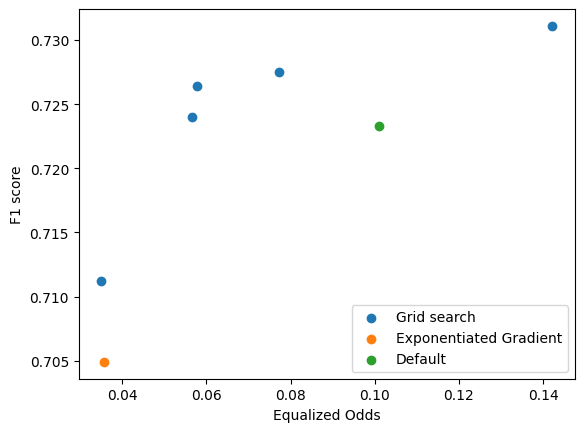

In [7]:
# Grid search
predictors = sweep.predictors_
score_list = []
for predictor in predictors:
    pred = predictor.predict(X_test)
    score_list.append((f1_score(y_test, pred), equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex'])))

f1_list = []
eo_list = []
min_f1 = 0
for f1, eo in sorted(score_list, key=lambda x: x[1]):
    if f1 > min_f1:
        min_f1 = f1
        f1_list.append(f1)
        eo_list.append(eo)
plt.scatter(eo_list, f1_list, label='Grid search')

# Exponentiated gradient
pred = mitigator.predict(X_test)
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred), label='Exponentiated Gradient')

# Default
pred = model.predict(X_test)
plt.scatter(equalized_odds_difference(y_test, pred, sensitive_features=X_test['sex']), f1_score(y_test, pred),  label='Default')
plt.legend()

plt.xlabel('Equalized Odds')
plt.ylabel('F1 score')
plt.show()

# おわりに

### 今回の結果
Reductionによってモデルの公平性を改善できることが確認できました。  
Grid Searchでは、F1スコアを落とさずに、Equalized Oddsを改善できたモデルもあることが分かりました。  


### 次にやること  
公平性を改善する手法は、Reduction以外も提案されているので、他の手法も検証したいと思います。

### 参考資料
- Adult Data Set  
http://archive.ics.uci.edu/ml/datasets/adult
- Fairlearn  
https://fairlearn.org/v0.8/quickstart.html
- A. Agarwal et al., A Reductions Approach to Fair Classification, ICML, 2018.
